# AutoMM for Scanned Document Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/document_prediction/document_classification.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/multimodal/document_prediction/document_classification.ipynb)



Paper documents in an organization are a crucial source of information, regardless of industry.
Dealing with paper documents is a headache because they can occupy a significant amount of space, can easily wear or fade with time, and are difficult to keep track of.
As such, there is a growing trend to digitizing paper documents via scanners, cameras, etc.
However, digitization does not necessarily bring automation, and identifying, categorizing, and analyzing digital documents can still be a labor-intensive process.
For example, classifying digital books into different genres, and categorizing scanned receipts into *utilities*, *transportation*, *insurance*, *rent*, *supplies*, etc. are time-consuming and tiresome if done manually.
With newer AI technologies, automating digital document processing becomes easier and more effective.
It’s fair to say that AI has been the bedrock of modern digital document processing systems.

In this tutorial, we show how you can build a scanned document classifier with Autogluon Multimodal using a few lines of code. Let’s get started!

## Get a Document Dataset
Now let's download a scanned document dataset.
This dataset is a sample of [RVL-CDIP](https://huggingface.co/datasets/rvl_cdip) which originally consists of 400,000 grayscale images in 16 classes, with 25,000 images per class.
Here, we sampled around 100 documents and three categories of document including budget (labelled as 0), email (labelled as 1), and form (labelled as 2).

In [ ]:
!pip install autogluon.multimodal

In [ ]:
!pip install autogluon
!pip install torch torchvision torchaudio transformers

In [ ]:
!pip uninstall torch torchaudio -y
!pip install torch torchvision torchaudio

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchaudio 2.3.1
Uninstalling torchaudio-2.3.1:
  Successfully uninstalled torchaudio-2.3.1
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchaudio-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached torchaudio-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached torchaudio-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.4 kB)
Using cached torc

In [ ]:
!pip install autogluon --upgrade

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
from autogluon.core.utils.loaders import load_zip

download_dir = './ag_automm_tutorial_doc_classifier'
zip_file = "https://automl-mm-bench.s3.amazonaws.com/doc_classification/rvl_cdip_sample.zip"
load_zip.unzip(zip_file, unzip_dir=download_dir)

We load the training and test data below.

In [ ]:
dataset_path = os.path.join(download_dir, "rvl_cdip_sample")
rvl_cdip_data = pd.read_csv(f"{dataset_path}/rvl_cdip_train_data.csv")
train_data = rvl_cdip_data.sample(frac=0.8, random_state=200)
test_data = rvl_cdip_data.drop(train_data.index)

We need to expand the document paths to load them in training.

In [ ]:
from autogluon.multimodal.utils.misc import path_expander

DOC_PATH_COL = "doc_path"

train_data[DOC_PATH_COL] = train_data[DOC_PATH_COL].apply(lambda ele: path_expander(ele, base_folder=download_dir))
test_data[DOC_PATH_COL] = test_data[DOC_PATH_COL].apply(lambda ele: path_expander(ele, base_folder=download_dir))
print(test_data.head())

                                             doc_path  label
1   /content/ag_automm_tutorial_doc_classifier/rvl...      0
6   /content/ag_automm_tutorial_doc_classifier/rvl...      0
7   /content/ag_automm_tutorial_doc_classifier/rvl...      0
11  /content/ag_automm_tutorial_doc_classifier/rvl...      0
14  /content/ag_automm_tutorial_doc_classifier/rvl...      0


Let's display one of the document.
As you can see, this is a budget document consisting of account number, account name, budgeted fund, expenditures, and etc.

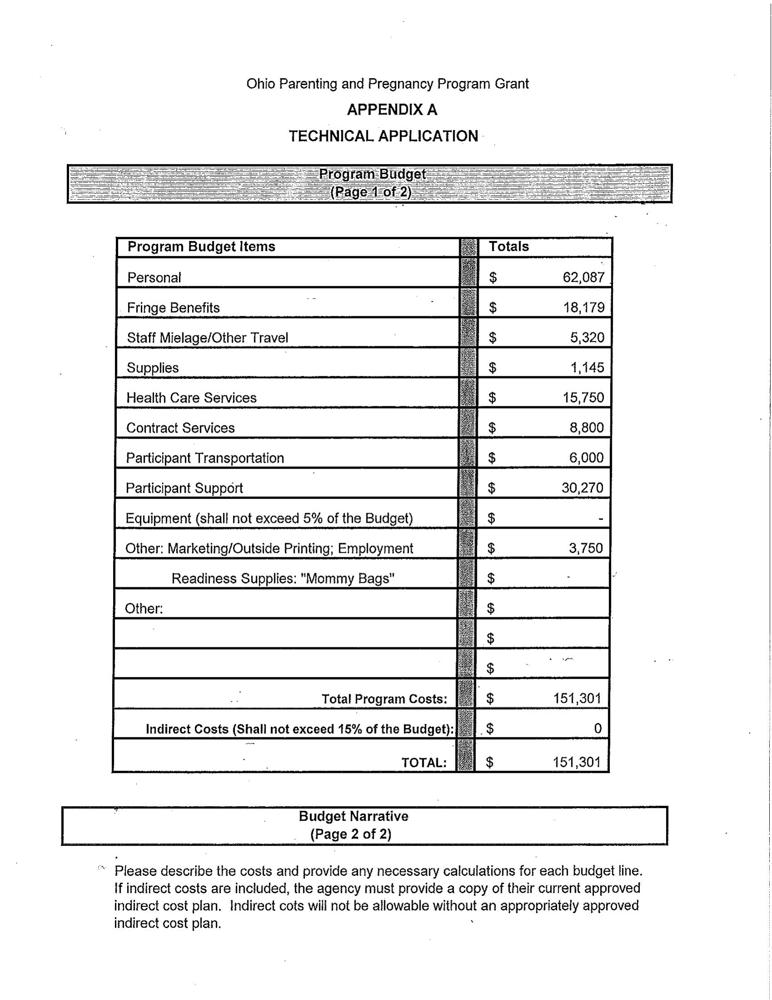

In [ ]:
from IPython.display import Image, display

example_image = train_data.iloc[1][DOC_PATH_COL]
pil_img = Image(filename=example_image, width=500)
display(pil_img)

## Build a Scanned Document Classifier with AutoMM

You can build a scanned document classifier with our MultiModalPredictor.
All you need to do is to create a predictor and fit it with the above training dataset.
Under the hood, AutoMM will automatically recognize handwritten or typed text, and make use of the recognized text, layout information, as well as the visual features for document classification.
Model customization is also quite simple, you can specify the underline foundation model using the `model.document_transformer.checkpoint_name` hyperparameter and AutoMM support document foundation models such as [layoutlmv3](https://huggingface.co/microsoft/layoutlmv3-base), [layoutlmv2](https://huggingface.co/microsoft/layoutlmv2-base-uncased), [layoutlm-base](https://huggingface.co/microsoft/layoutlm-base-uncased), [layoutxlm](https://huggingface.co/docs/transformers/model_doc/layoutxlm), etc.,
as well as pure text models like [bert](https://huggingface.co/bert-base-uncased), [deberta](https://huggingface.co/microsoft/deberta-v3-base), just to name a few.

Here, `label` is the name of the column that contains the target variable to predict, e.g., it is “label” in our example.
We set the training time limit to 120 seconds for demonstration purposes.

In [ ]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(label="label")
predictor.fit(
    train_data=train_data,
    hyperparameters={"model.document_transformer.checkpoint_name":"microsoft/layoutlm-base-uncased",
    "optimization.top_k_average_method":"best",
    },
    time_limit=120,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240926_022939"
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.3.1+cu121
CUDA Version:       CUDA is not available
Memory Avail:       10.47 GB / 12.67 GB (82.6%)
Disk Space Avail:   179.48 GB / 225.83 GB (79.5%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:02:26. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20240926_022939")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




## Evaluate on Test Dataset

You can evaluate the classifier on the test dataset to see how it performs:

In [ ]:
scores = predictor.evaluate(test_data, metrics=["accuracy"])
print('The test acc: %.3f' % scores["accuracy"])

Predicting: |          | 0/? [00:00<?, ?it/s]

The test acc: 0.500


## Predict on a New Document

Given an example document, let’s visualize it first,

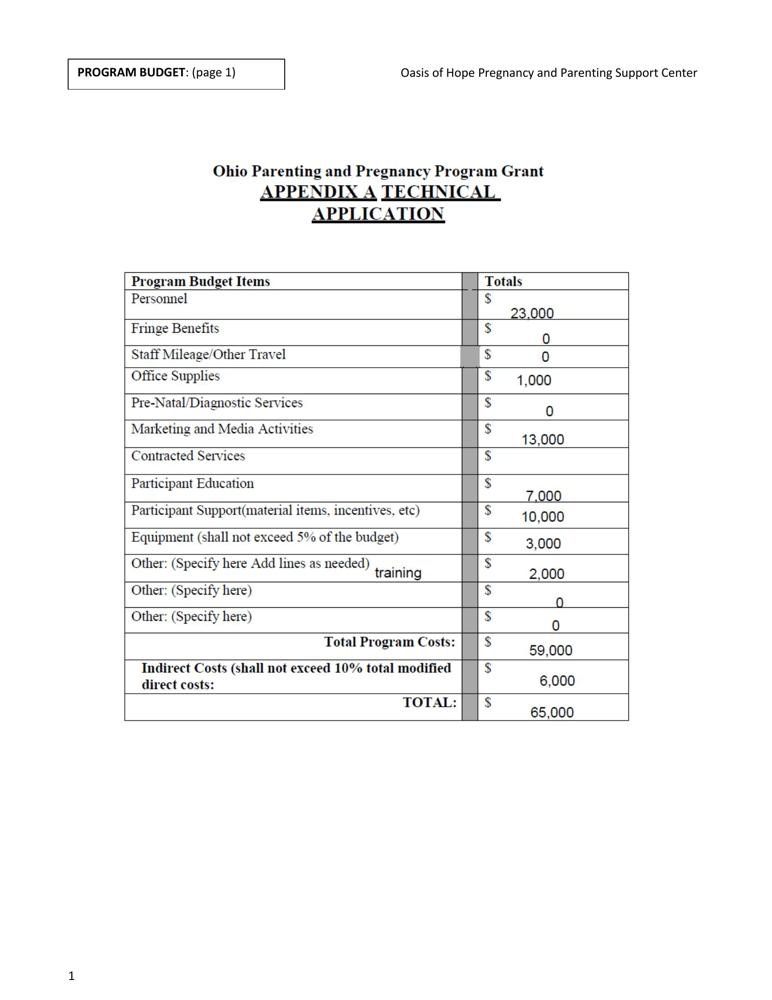

In [ ]:
doc_path = test_data.iloc[1][DOC_PATH_COL]
from IPython.display import Image, display
pil_img = Image(filename=doc_path, width=500)
display(pil_img)

We can easily use the final model to predict the label,

In [ ]:
predictions = predictor.predict({DOC_PATH_COL: [doc_path]})
print(predictions)

Predicting: |          | 0/? [00:00<?, ?it/s]

[0]


The above output shows that the trained model correctly classifies the given document into the *budget* category.

If probabilities of all categories are needed, you can call predict_proba:

In [ ]:
proba = predictor.predict_proba({DOC_PATH_COL: [doc_path]})
print(proba)

Predicting: |          | 0/? [00:00<?, ?it/s]

[[0.39313683 0.3371671  0.26969606]]


## Extract Embeddings

Extracting representation from the whole document learned by a model is also very useful.
We provide extract_embedding function to allow predictor to return the N-dimensional document feature where N depends on the model.

In [ ]:
feature = predictor.extract_embedding({DOC_PATH_COL: [doc_path]})
print(feature[0].shape)

Predicting: |          | 0/? [00:00<?, ?it/s]

(768,)


## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization

To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).